In [3]:
import pandas as pd,os,SenaoDB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
db=SenaoDB.DB()
conn=db._conn

In [5]:
os.chdir(r'C:\Users\018363\Project\20240306_推薦系統HDBSCAN')

In [6]:
sql="""
select * from ptest.Group_recommend_result 
order by second_cat::int  asc
"""
df=pd.read_sql(sql,conn)
df.shape

C:\Users\018363\AppData\Local\Temp\ipykernel_14452\784687673.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(sql,conn)


(900, 9)

In [7]:
df.head()

,main_cat,second_cat,mart_code,mart_name,mart_status,qty,seq,created_by,creation_date
0,hdbscan,-1,1332708,【週期購】sakuyo 芝麻元氣軟膠囊(60粒/瓶),2,20,30,ETL,2024-03-22 14:09:04.800160
1,hdbscan,-1,1342240,★爆殺95折現貨★iPhone 15 Pro 128GB【贈保貼兌換券】,2,14,31,ETL,2024-03-22 14:09:04.800160
2,hdbscan,-1,1330609,★爆殺95折現貨★iPhone 15 Pro Max 512GB【贈保貼兌換券】,2,13,33,ETL,2024-03-22 14:09:04.800160
3,hdbscan,-1,1344832,ASUS Zenfone 11 Ultra 12G/256G【新機上市 贈神腦幣】,2,3,78,ETL,2024-03-22 14:09:04.800160
4,hdbscan,-1,1322517,HTC U23 Pro 12G+256G【S級福利品 6個月保固】,2,14,32,ETL,2024-03-22 14:09:04.800160


In [ ]:
# [set(df[df['second_cat']==i]['mart_code']) for i in df['second_cat'].unique()]

In [ ]:
# df['second_cat'].unique()

In [8]:
def iou(set1, set2):
    # 計算兩個商品編號清單的 IOU
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    iou_value = intersection / union if union != 0 else 1  # 將 union 為 0 時的情況改為 1
    return iou_value

item_sets=[set(df[df['second_cat']==i]['mart_code']) for i in df['second_cat'].unique()]

# 計算兩兩相似度的 IOU
num_items = len(item_sets)
iou_matrix_result = np.zeros((num_items, num_items))

for i in range(num_items):
    for j in range(num_items):
        iou_matrix_result[i, j] = iou(item_sets[i], item_sets[j])

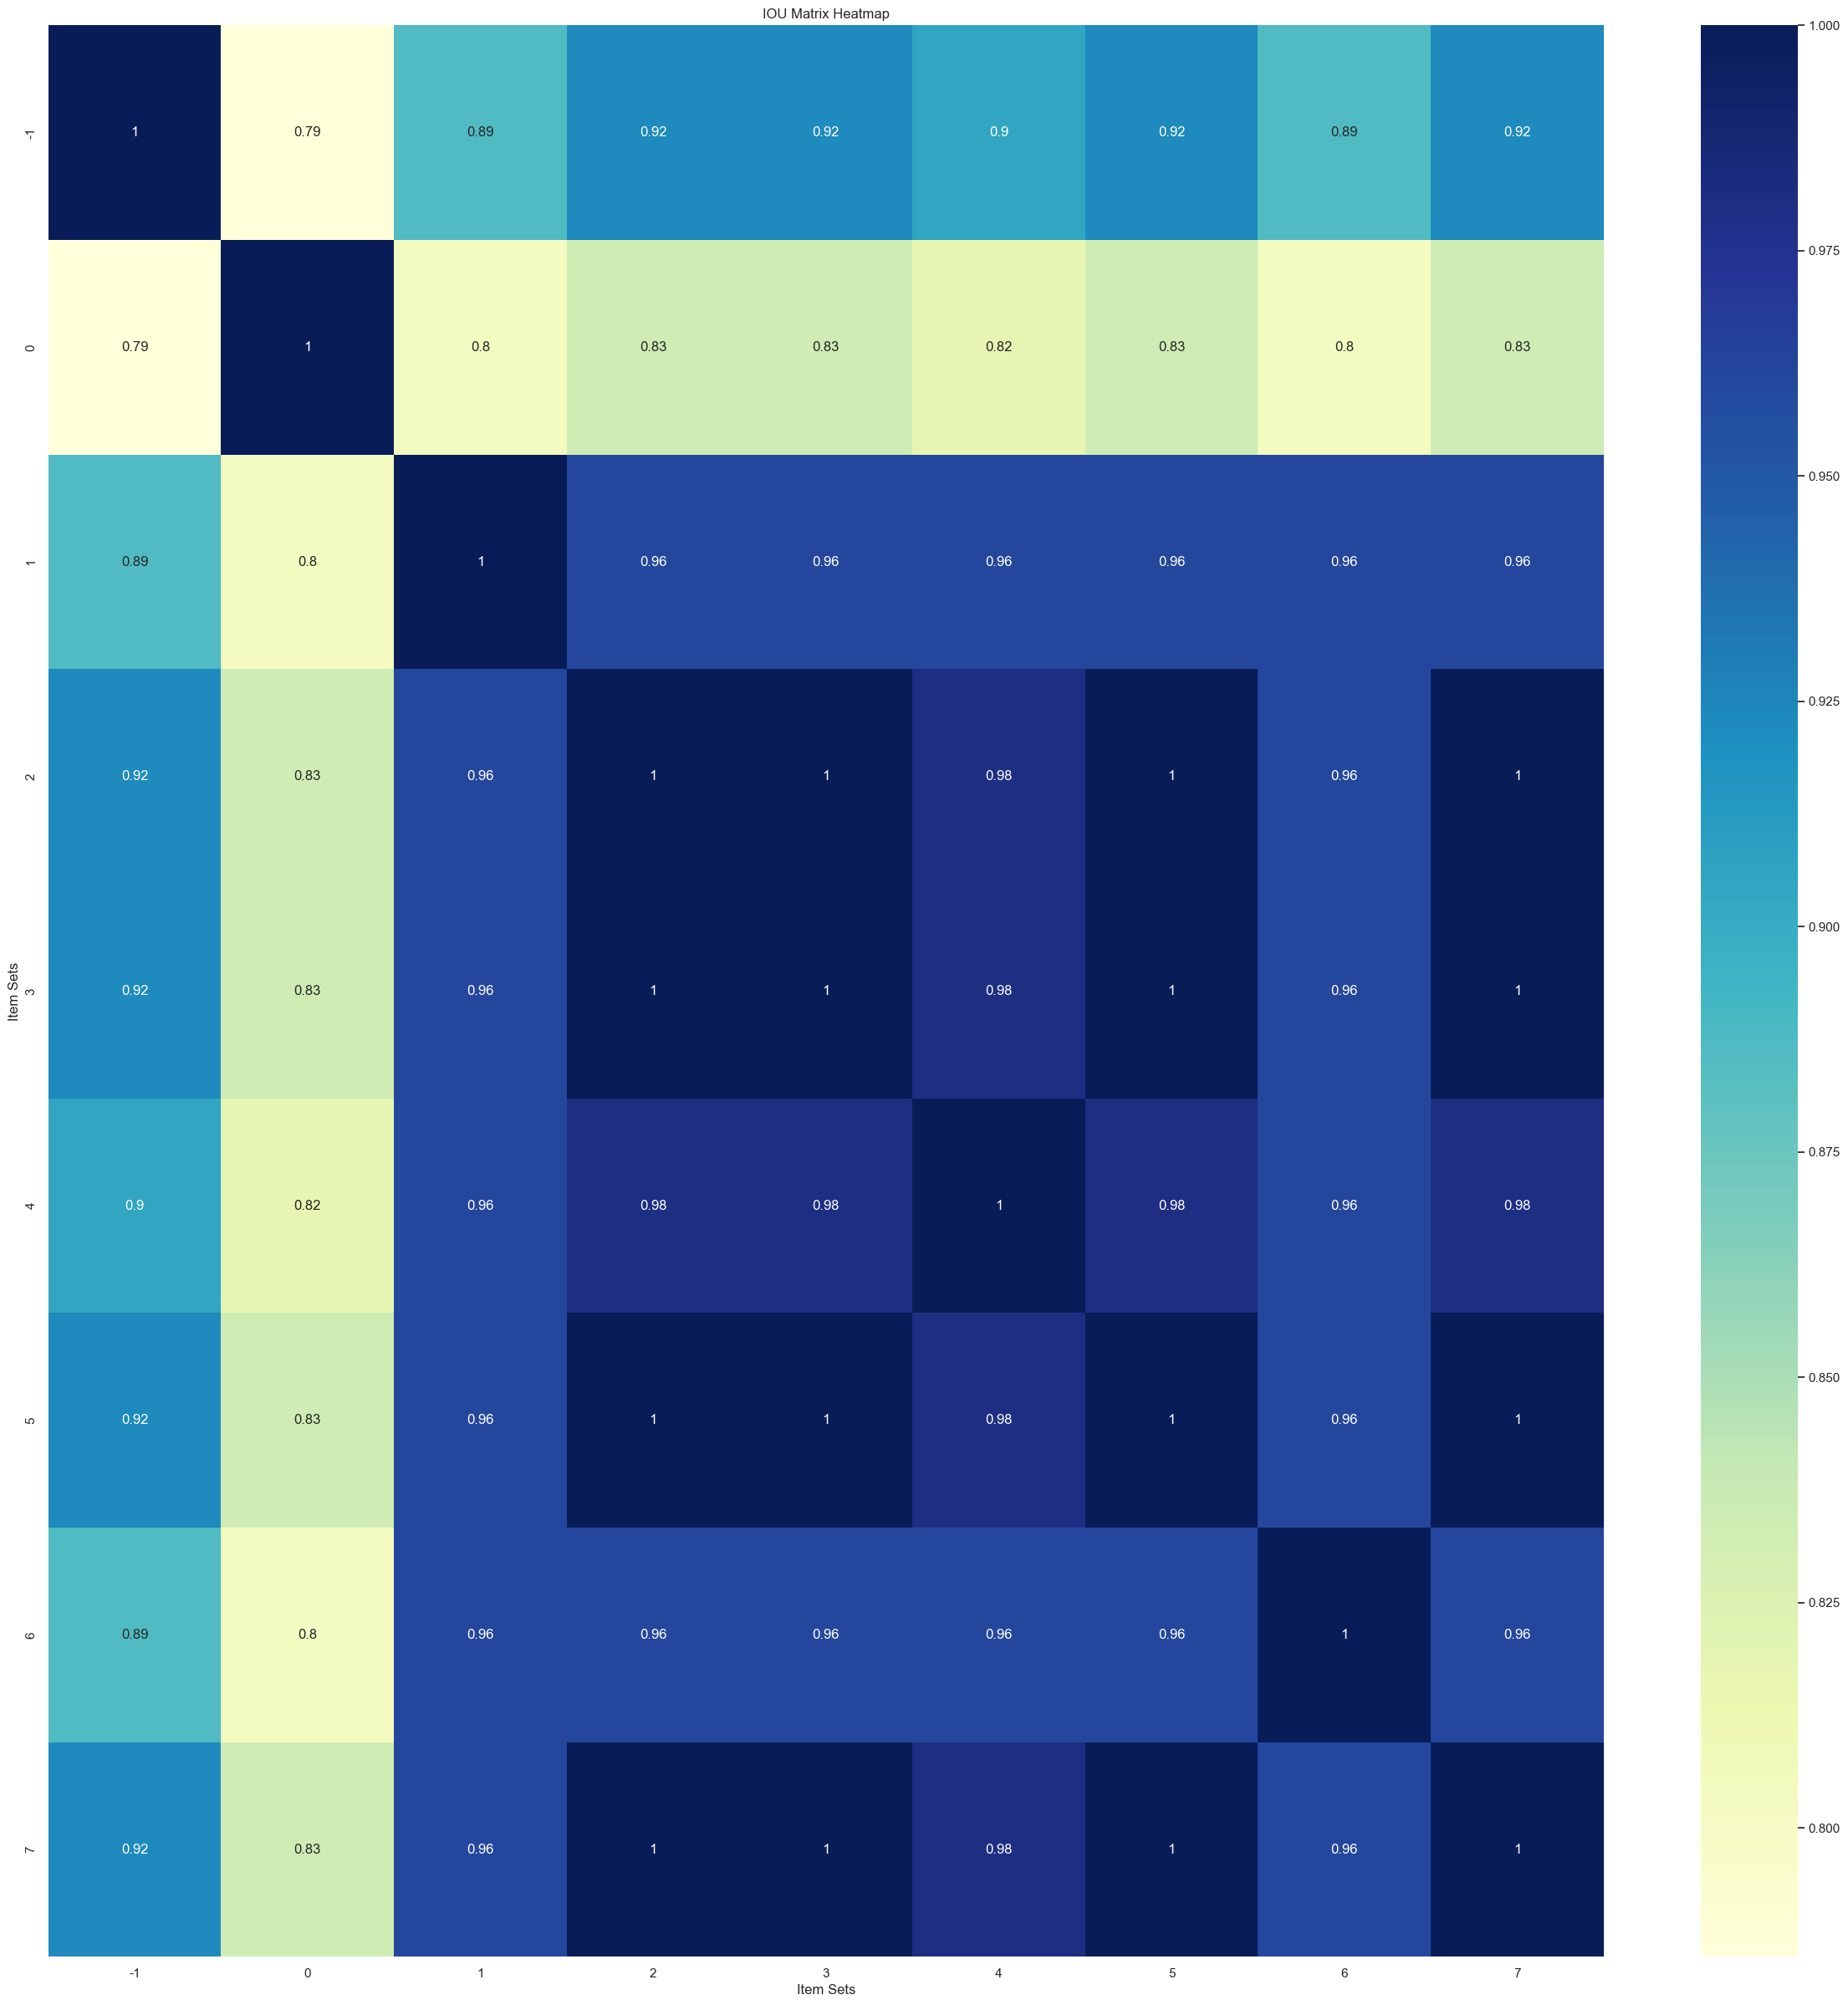

In [9]:
# 使用 seaborn 創建熱視圖
sns.set()
plt.figure(figsize=(30, 30))
sns.heatmap(iou_matrix_result, annot=True, cmap="YlGnBu",
            xticklabels=list(df['second_cat'].unique()),
            yticklabels=list(df['second_cat'].unique())
           )
plt.title('IOU Matrix Heatmap')
plt.xlabel('Item Sets')
plt.ylabel('Item Sets')
filename='包含遞補賣場.png'
plt.savefig(filename)
plt.show()

# 排除遞補的賣場，看相似度

In [19]:
sql="""
--step1.執行迴圈
truncate table ptest.Group_recommend_result_nofillup;

select ptest.anio_recommend_by_cluster_hdbscan_nofillup();
"""
db.cursor.execute(sql)
db.connection.commit()

In [20]:
sql="""
select * from ptest.Group_recommend_result_nofillup 
order by second_cat::int  asc
"""
df1=pd.read_sql(sql,conn)

C:\Users\018363\AppData\Local\Temp\ipykernel_14452\2548673600.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1=pd.read_sql(sql,conn)


In [21]:
df1.shape

(95, 9)

In [22]:
#觀察各群人數以及推薦賣場數量
sql="""
with t as (
SELECT "Group",count(*) as member_cnt from ptest."anio_hdbscan_result" 
group by "Group"
)select t.*,coalesce(B.mart_cnt,0) from t
left join (
select second_cat,count(mart_code) as mart_cnt from ptest.Group_recommend_result_nofillup 
group by second_cat
) B on t."Group"=B.second_cat
order by t."Group"::int asc
"""
tp=pd.read_sql(sql,conn)
tp

C:\Users\018363\AppData\Local\Temp\ipykernel_14452\210615479.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tp=pd.read_sql(sql,conn)


,Group,member_cnt,coalesce
0,-1,1080,27
1,0,1376,50
2,1,678,4
3,2,1307,1
4,3,1471,3
5,4,1377,3
6,5,921,2
7,6,931,5
8,7,859,0


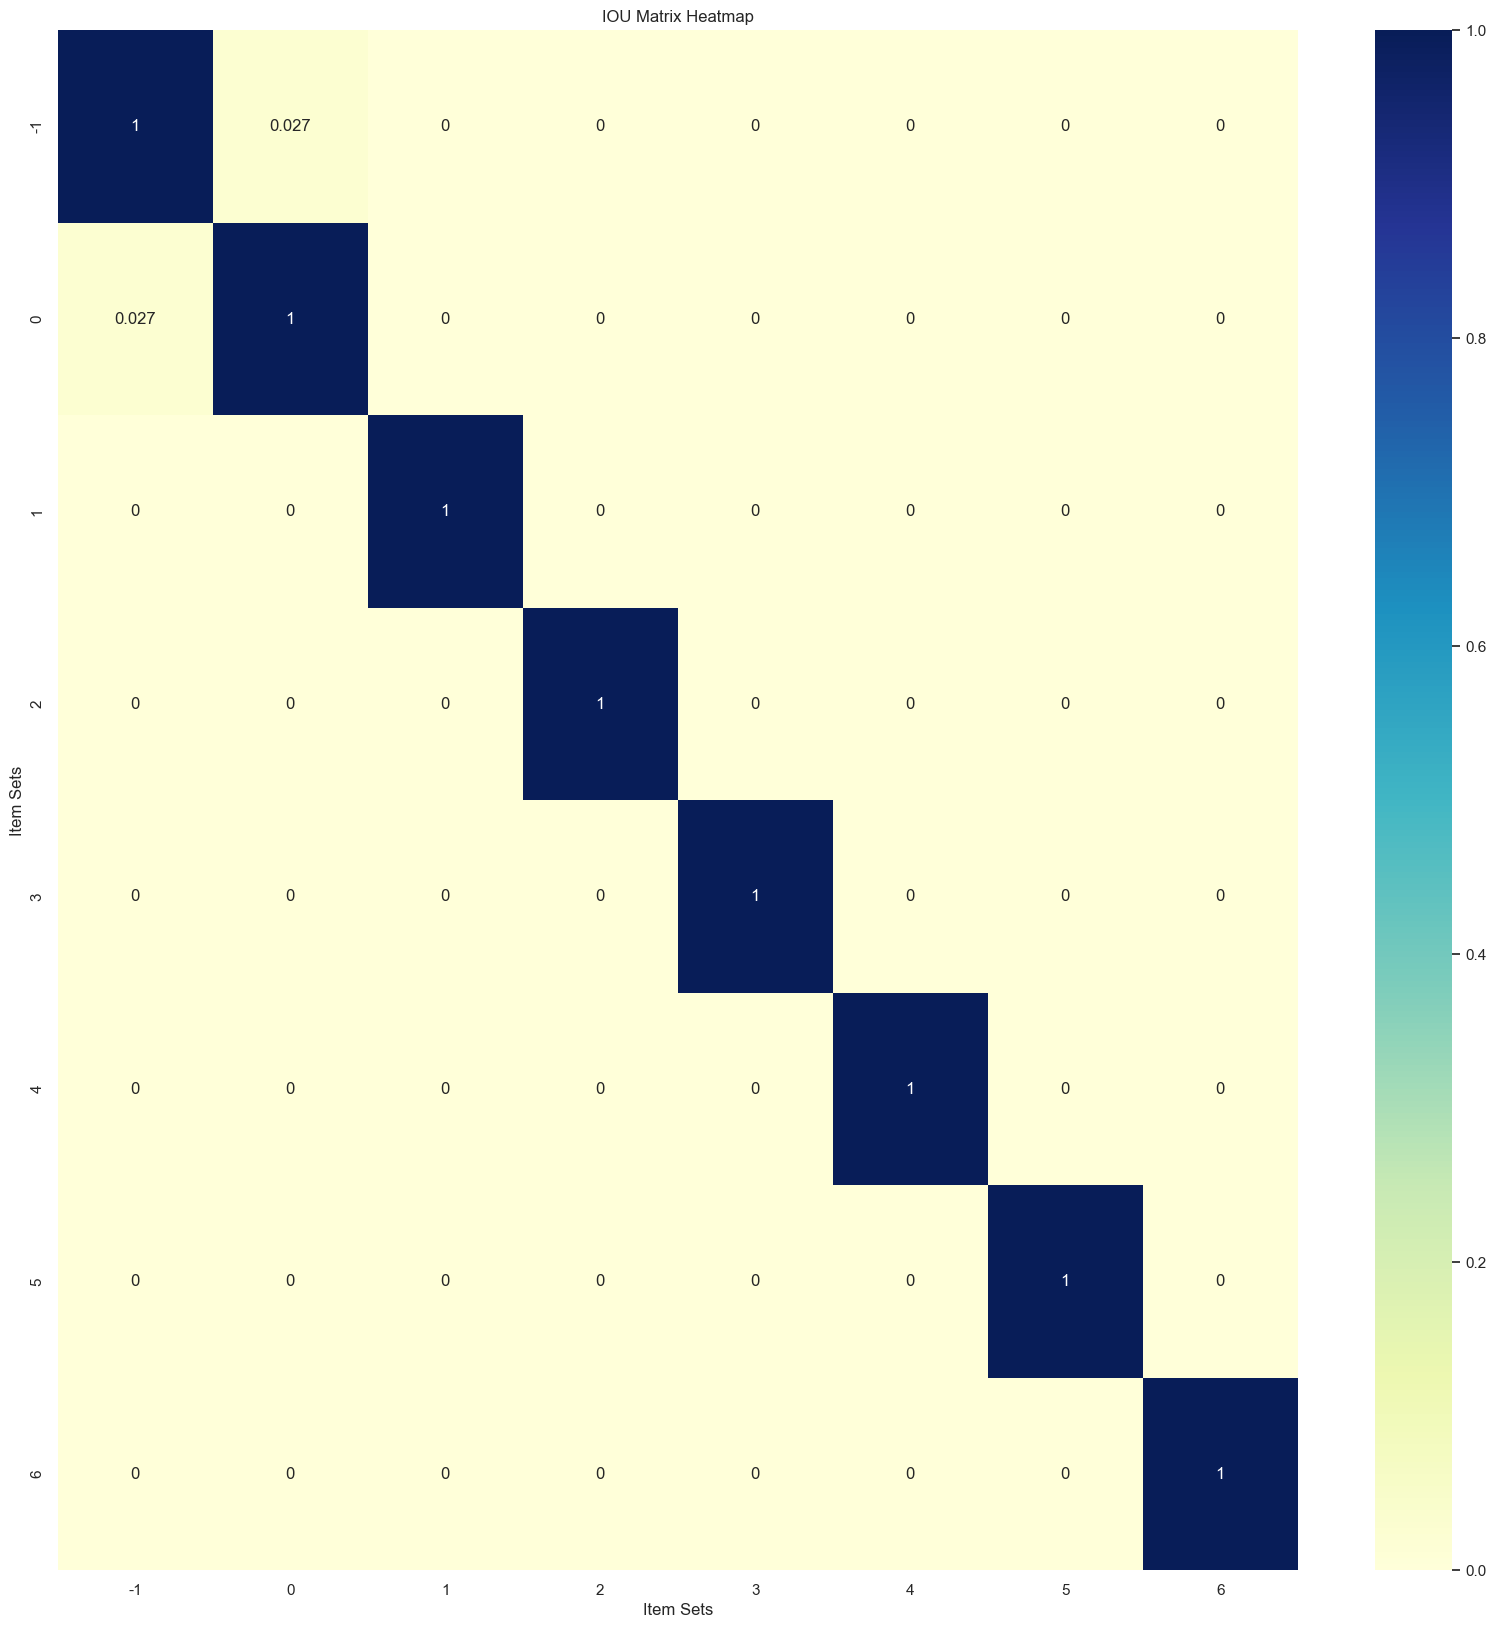

In [25]:
item_sets=[set(df1[df1['second_cat']==i]['mart_code']) for i in df1['second_cat'].unique()]

# 計算兩兩相似度的 IOU
num_items = len(item_sets)
iou_matrix_result = np.zeros((num_items, num_items))

for i in range(num_items):
    for j in range(num_items):
        iou_matrix_result[i, j] = iou(item_sets[i], item_sets[j])

# 使用 seaborn 創建熱視圖
sns.set()
plt.figure(figsize=(20, 20))
sns.heatmap(iou_matrix_result, annot=True, cmap="YlGnBu", 
            xticklabels=list(df1['second_cat'].unique()),
            yticklabels=list(df1['second_cat'].unique())
           )
plt.title('IOU Matrix Heatmap')
plt.xlabel('Item Sets')
plt.ylabel('Item Sets')

filename='未遞補.png'
plt.savefig(filename)
plt.show()

In [ ]:
#觀察指定群的賣場
# df1[df1['second_cat']=='34']

In [ ]:
# iou(item_sets[33], item_sets[5])

In [ ]:
# item_sets[33]